# Preparation

In [13]:
%matplotlib inline

import json
import random
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

In [14]:
# Preparation: Load the dataset

def load_jsonl(file_path):
    """Load a JSONL file and return a list of dictionaries."""
    with open(file_path, 'r', encoding='utf-8') as f:
        return [json.loads(line) for line in f]

# Load train, validation, and test sets
train_data = load_jsonl("data/train_en.jsonl")
val_data = load_jsonl("data/val_en.jsonl")
test_data = load_jsonl("data/test_en.jsonl")

print("Datasets loaded successfully.")

Datasets loaded successfully.


Preview the dataset

In [15]:
# Preview the loaded datasets
print(f"Train Data: {len(train_data)} sentences")
print(f"Validation Data: {len(val_data)} sentences")
print(f"Test Data: {len(test_data)} sentences")

# Preview a sample
print("\nExample from Train Data:")
print(train_data[0])

Train Data: 131280 sentences
Validation Data: 16410 sentences
Test Data: 16454 sentences

Example from Train Data:
{'tokens': ['The', 'type', 'locality', 'is', 'Kīlauea', '.'], 'ner_tags': [0, 0, 0, 0, 5, 0], 'lang': 'en'}


# EDA Functions

In [16]:
# Data Analysis Functions

def dataset_overview(dataset, name="Dataset"):
    print(f"# {name} - Dataset Overview\n")
    sentence_lengths = [len(item['tokens']) for item in dataset]
    print(f"- Number of sentences: {len(dataset)}")
    print(f"- Total tokens: {sum(sentence_lengths)}")
    print(f"- Average sentence length: {np.mean(sentence_lengths):.2f} tokens")
    print(f"- Max sentence length: {np.max(sentence_lengths)} tokens")
    print(f"- Min sentence length: {np.min(sentence_lengths)} tokens")
    print("\n" + "-"*50 + "\n")

def clean_dataset(dataset, name="Dataset"):
    print(f"# {name} - Cleaning Missing Data\n")
    initial_len = len(dataset)
    cleaned_dataset = [
        item for item in dataset
        if item.get('tokens') and item.get('ner_tags') and len(item['tokens']) == len(item['ner_tags'])
    ]
    removed = initial_len - len(cleaned_dataset)
    print(f"- Removed {removed} invalid samples.\n")
    return cleaned_dataset

def plot_ner_distribution(dataset, name="Dataset"):
    print(f"# {name} - NER Tag Distribution (%)\n")
    all_labels = [tag for item in dataset for tag in item['ner_tags']]
    label_counter = Counter(all_labels)
    
    total = sum(label_counter.values())
    label_percentages = {tag: (count/total)*100 for tag, count in label_counter.items()}
    
    for tag, percent in sorted(label_percentages.items()):
        print(f"Tag {tag}: {percent:.2f}%")
    
    plt.figure(figsize=(12, 6))
    plt.bar(label_percentages.keys(), label_percentages.values(), color='skyblue')
    plt.title(f"{name} - NER Tag Distribution (%)")
    plt.xlabel("NER Tag ID")
    plt.ylabel("Percentage (%)")
    plt.xticks(list(label_percentages.keys()), rotation=90)
    plt.tight_layout()
    plt.show()

def sentence_length_analysis(dataset, name="Dataset"):
    print(f"# {name} - Sentence Length Analysis\n")
    sentence_lengths = [len(item['tokens']) for item in dataset]
    print(f"- Average: {np.mean(sentence_lengths):.2f}")
    print(f"- Max: {np.max(sentence_lengths)}")
    print(f"- Min: {np.min(sentence_lengths)}")
    
    plt.figure(figsize=(10, 6))
    plt.hist(sentence_lengths, bins=30, color='lightgreen', edgecolor='black')
    plt.title(f"{name} - Sentence Length Distribution")
    plt.xlabel("Sentence Length (tokens)")
    plt.ylabel("Number of Sentences")
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

def entity_span_analysis(dataset, name="Dataset"):
    print(f"# {name} - Entity Span Analysis\n")
    span_lengths = []
    for item in dataset:
        span = 0
        for tag in item['ner_tags']:
            if tag > 0:
                span += 1
            else:
                if span > 0:
                    span_lengths.append(span)
                    span = 0
        if span > 0:
            span_lengths.append(span)
    
    if span_lengths:
        print(f"- Total entities: {len(span_lengths)}")
        print(f"- Average entity span: {np.mean(span_lengths):.2f} tokens")
        print(f"- Max span: {max(span_lengths)} tokens")
        print(f"- Min span: {min(span_lengths)} tokens")
        
        plt.figure(figsize=(10, 6))
        plt.hist(span_lengths, bins=range(1, max(span_lengths)+2), align='left', color='lightcoral', edgecolor='black')
        plt.title(f"{name} - Entity Span Length Distribution")
        plt.xlabel("Entity Span Length (tokens)")
        plt.ylabel("Number of Entities")
        plt.xticks(range(1, max(span_lengths)+1))
        plt.grid(axis='y')
        plt.tight_layout()
        plt.show()
    else:
        print("- No entities found!\n")

def preview_random_sentences(dataset, name="Dataset", n=3):
    print(f"# {name} - Random Sentence Samples\n")
    for i in range(n):
        example = random.choice(dataset)
        print(f"Sentence {i+1}:")
        print("Tokens:", " ".join(example['tokens']))
        print("NER Tags:", example['ner_tags'])
        print("\n" + "-"*50 + "\n")


# Data Analasys

## Train Dataset

### Clean Dataset

In [17]:
train_data = clean_dataset(train_data, name="Train")

# Train - Cleaning Missing Data

- Removed 0 invalid samples.



### Overview

In [18]:
dataset_overview(train_data, name="Train")

# Train - Dataset Overview

- Number of sentences: 131280
- Total tokens: 2842119
- Average sentence length: 21.65 tokens
- Max sentence length: 237 tokens
- Min sentence length: 2 tokens

--------------------------------------------------



### NER Tag Distribution
Analyze the frequency of each NER tag in the dataset and visualize the distribution.

# Train - NER Tag Distribution (%)

Tag 0: 87.21%
Tag 1: 2.22%
Tag 2: 2.33%
Tag 3: 0.97%
Tag 4: 1.27%
Tag 5: 2.06%
Tag 6: 0.86%
Tag 7: 0.45%
Tag 8: 0.19%
Tag 9: 0.00%
Tag 10: 0.00%
Tag 11: 0.09%
Tag 12: 0.05%
Tag 13: 0.31%
Tag 14: 0.20%
Tag 15: 0.09%
Tag 16: 0.15%
Tag 17: 0.29%
Tag 18: 0.11%
Tag 19: 0.01%
Tag 20: 0.01%
Tag 21: 0.21%
Tag 22: 0.35%
Tag 23: 0.02%
Tag 24: 0.00%
Tag 25: 0.26%
Tag 26: 0.08%
Tag 27: 0.09%
Tag 28: 0.07%
Tag 29: 0.01%
Tag 30: 0.02%


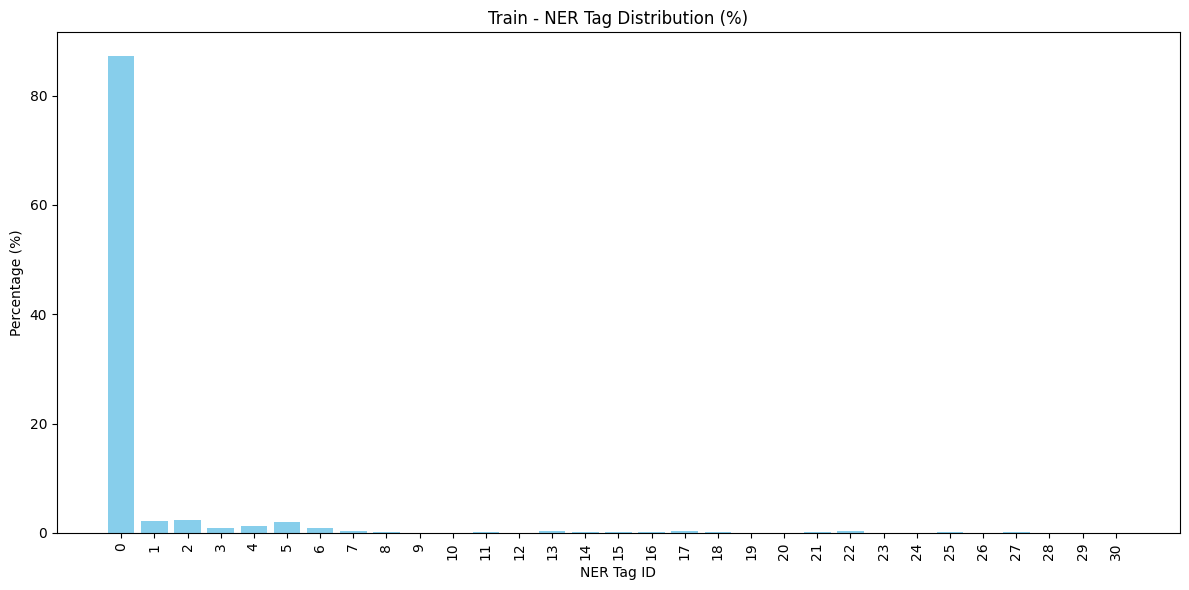

In [19]:
plot_ner_distribution(train_data, name="Train")

- Tag 0 ("O" label) dominates (~90% of data).

- Other tags are very rare (<5% each).

- Dataset is highly imbalanced.

### Sentence Length Analysis

# Train - Sentence Length Analysis

- Average: 21.65
- Max: 237
- Min: 2


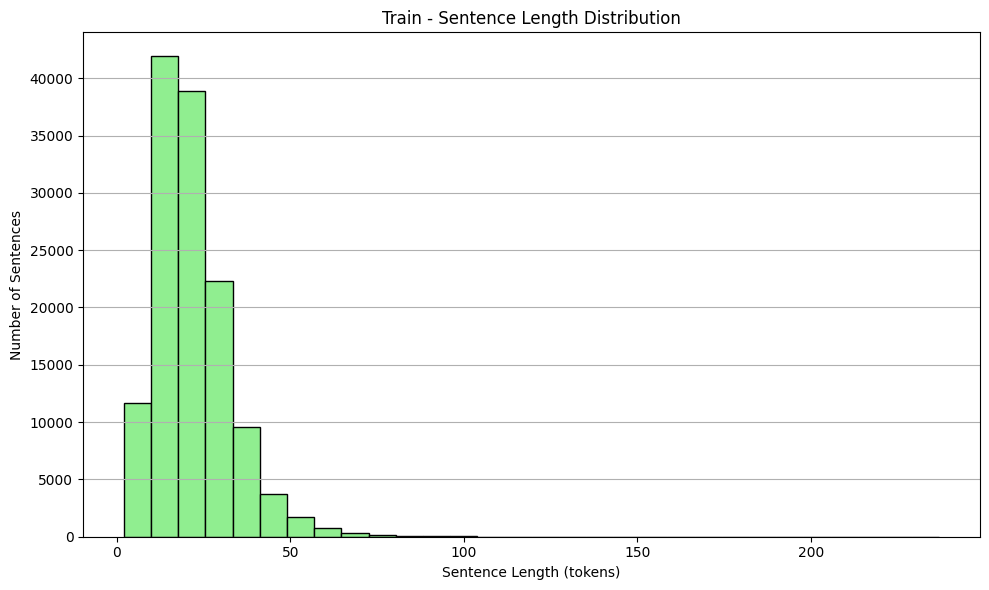

In [20]:
sentence_length_analysis(train_data, name="Train")

- Most sentences have 10–30 tokens.

- Few sentences are longer than 50 tokens.
- Very few outliers (over 100 tokens).

- Dataset is dominated by short to medium sentences.

### Entity Span Analysis

# Train - Entity Span Analysis

- Total entities: 201501
- Average entity span: 1.80 tokens
- Max span: 21 tokens
- Min span: 1 tokens


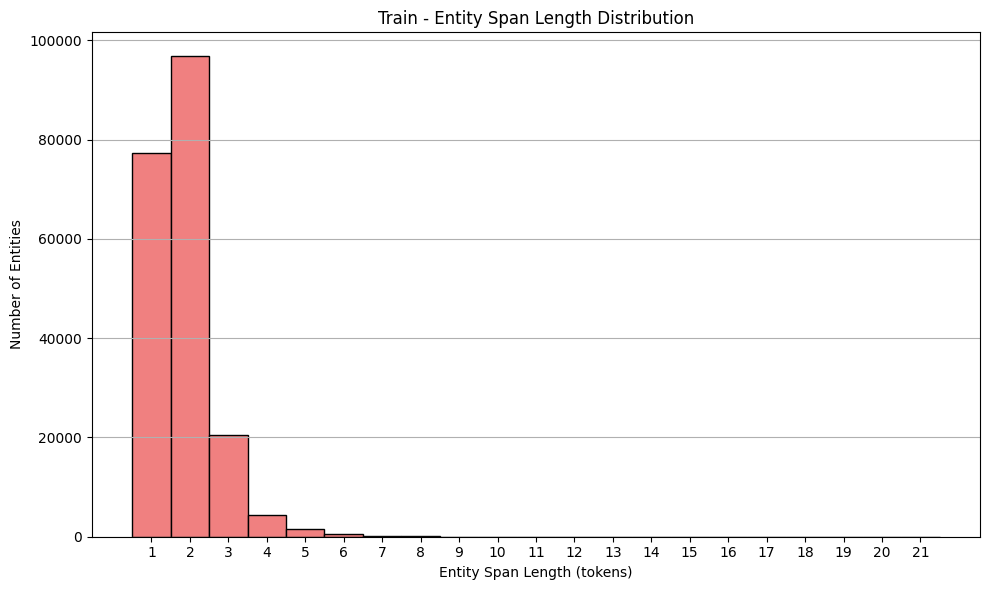

In [21]:
entity_span_analysis(train_data, name="Train")

- Most entities are 1–2 tokens long.

- Very few entities have more than 3 tokens.

- Long entities (>5 tokens) are extremely rare.

- Dataset mostly contains short named entities.

### Sample Sentences

In [22]:
preview_random_sentences(train_data, name="Train")

# Train - Random Sentence Samples

Sentence 1:
Tokens: At the invitation of George Eastman he was conductor of the Rochester Philharmonic Orchestra from 1923 to 1931 .
NER Tags: [0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 3, 4, 4, 0, 0, 0, 0, 0]

--------------------------------------------------

Sentence 2:
Tokens: At that time , he played in some team with players like Michael Essien captain of the SC Bastia in that period .
NER Tags: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 3, 4, 0, 0, 0, 0]

--------------------------------------------------

Sentence 3:
Tokens: In September 2005 , she made an official visit to China .
NER Tags: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0]

--------------------------------------------------



## Validation Dataset

### Clean Dataset

In [23]:
val_data = clean_dataset(val_data, name="Validation")

# Validation - Cleaning Missing Data

- Removed 0 invalid samples.



### Overview

In [24]:
dataset_overview(val_data, name="Validation")

# Validation - Dataset Overview

- Number of sentences: 16410
- Total tokens: 379011
- Average sentence length: 23.10 tokens
- Max sentence length: 170 tokens
- Min sentence length: 2 tokens

--------------------------------------------------



### NER Tag Distribution
Analyze the frequency of each NER tag in the dataset and visualize the distribution.

# Validation - NER Tag Distribution (%)

Tag 0: 87.61%
Tag 1: 1.98%
Tag 2: 2.11%
Tag 3: 0.72%
Tag 4: 1.03%
Tag 5: 2.07%
Tag 6: 0.95%
Tag 7: 0.30%
Tag 8: 0.15%
Tag 9: 0.00%
Tag 10: 0.00%
Tag 11: 0.02%
Tag 12: 0.01%
Tag 13: 0.45%
Tag 14: 0.33%
Tag 15: 0.08%
Tag 16: 0.14%
Tag 17: 0.56%
Tag 18: 0.22%
Tag 19: 0.01%
Tag 20: 0.01%
Tag 21: 0.24%
Tag 22: 0.37%
Tag 23: 0.01%
Tag 24: 0.00%
Tag 25: 0.31%
Tag 26: 0.11%
Tag 27: 0.08%
Tag 28: 0.07%
Tag 29: 0.02%
Tag 30: 0.02%


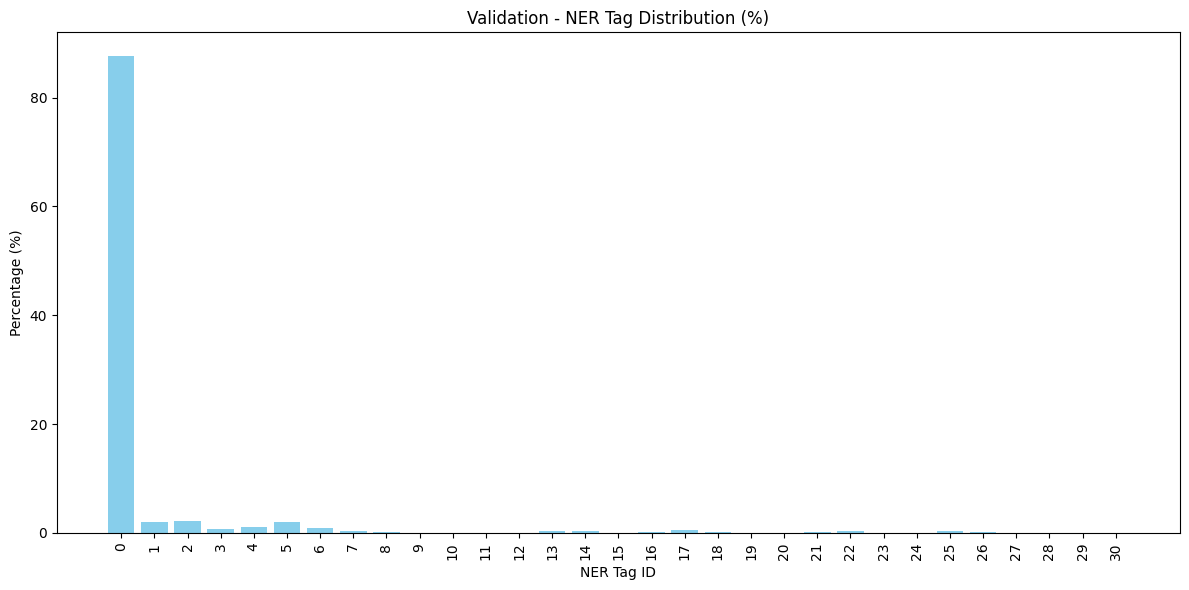

In [25]:
plot_ner_distribution(val_data, name="Validation")

- Tag 0 ("O" label) still dominates (~85–90%).

- Other tags are very rare (<5% each), similar to Train set.

- Label imbalance remains strong in Validation set.

### Sentence Length Analysis

# Validation - Sentence Length Analysis

- Average: 23.10
- Max: 170
- Min: 2


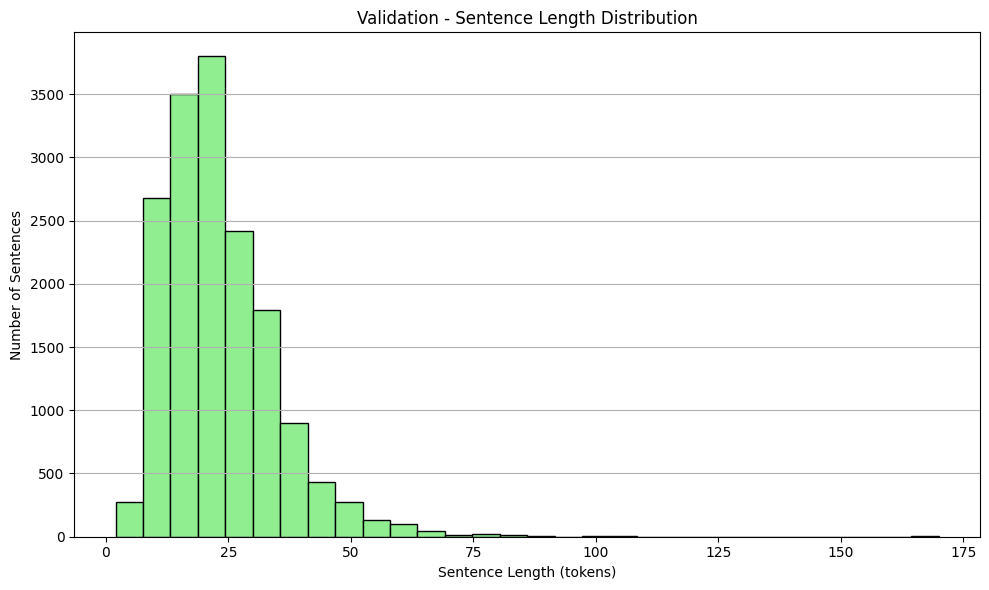

In [26]:
sentence_length_analysis(val_data, name="Validation")

- Most sentences are around 15–30 tokens.

- Only a few sentences are longer than 50 tokens.

- Long sentences (>100 tokens) are very rare.

- Overall, validation sentences are short to medium length, matching the train set pattern.



### Entity Span Analysis

# Validation - Entity Span Analysis

- Total entities: 26001
- Average entity span: 1.81 tokens
- Max span: 12 tokens
- Min span: 1 tokens


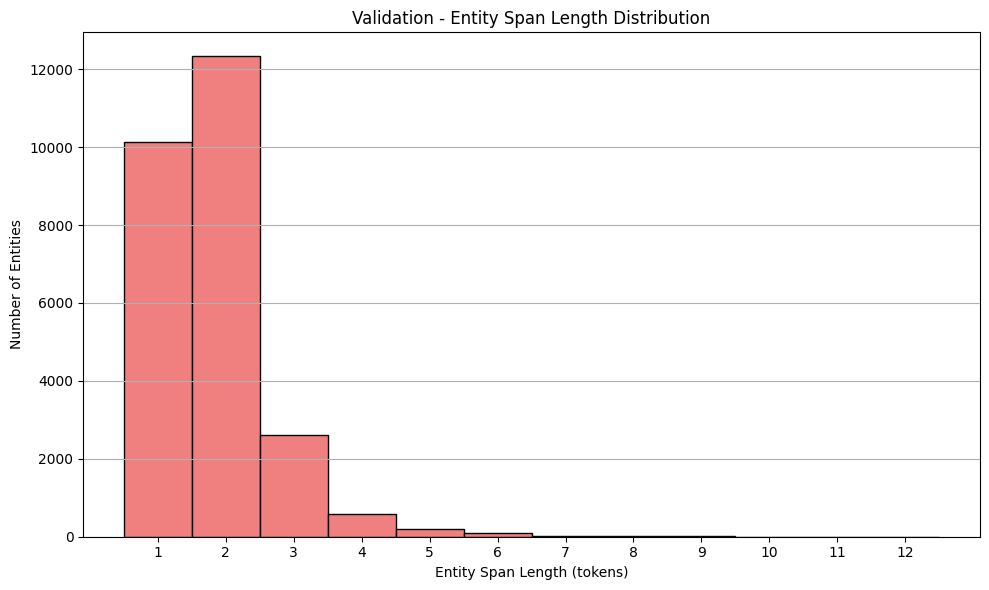

In [27]:
entity_span_analysis(val_data, name="Validation")

- Most entities are 1–2 tokens long.

- Very few entities have more than 3 tokens.

- Long entities (>5 tokens) are almost nonexistent.

### Sample Sentences

In [28]:
preview_random_sentences(val_data, name="Validation")

# Validation - Random Sentence Samples

Sentence 1:
Tokens: The maize flour is first boiled with water into a porridge .
NER Tags: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17, 0]

--------------------------------------------------

Sentence 2:
Tokens: Iain Balshaw kicked ahead and he touched down in the corner , with eight minutes of injury time played .
NER Tags: [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

--------------------------------------------------

Sentence 3:
Tokens: Found on deep rocky bottoms in the North Pacific at depths of up to 440 metres , they can reach up to 1.83 metres in length and weigh up to 91 kilograms .
NER Tags: [0, 0, 0, 0, 0, 0, 0, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

--------------------------------------------------



## Test Dataset

### Clean Dataset

In [29]:
test_data = clean_dataset(test_data, name="Test")

# Test - Cleaning Missing Data

- Removed 0 invalid samples.



### Overview

In [30]:
dataset_overview(test_data, name="Test")

# Test - Dataset Overview

- Number of sentences: 16454
- Total tokens: 347025
- Average sentence length: 21.09 tokens
- Max sentence length: 148 tokens
- Min sentence length: 4 tokens

--------------------------------------------------



### NER Tag Distribution
Analyze the frequency of each NER tag in the dataset and visualize the distribution.

# Test - NER Tag Distribution (%)

Tag 0: 86.86%
Tag 1: 1.52%
Tag 2: 1.65%
Tag 3: 0.95%
Tag 4: 1.32%
Tag 5: 3.46%
Tag 6: 1.72%
Tag 7: 0.46%
Tag 8: 0.27%
Tag 9: 0.00%
Tag 11: 0.01%
Tag 12: 0.00%
Tag 13: 0.22%
Tag 14: 0.14%
Tag 15: 0.10%
Tag 16: 0.18%
Tag 17: 0.16%
Tag 18: 0.05%
Tag 19: 0.00%
Tag 20: 0.00%
Tag 21: 0.13%
Tag 22: 0.22%
Tag 23: 0.01%
Tag 24: 0.00%
Tag 25: 0.26%
Tag 26: 0.11%
Tag 27: 0.08%
Tag 28: 0.06%
Tag 29: 0.01%
Tag 30: 0.01%


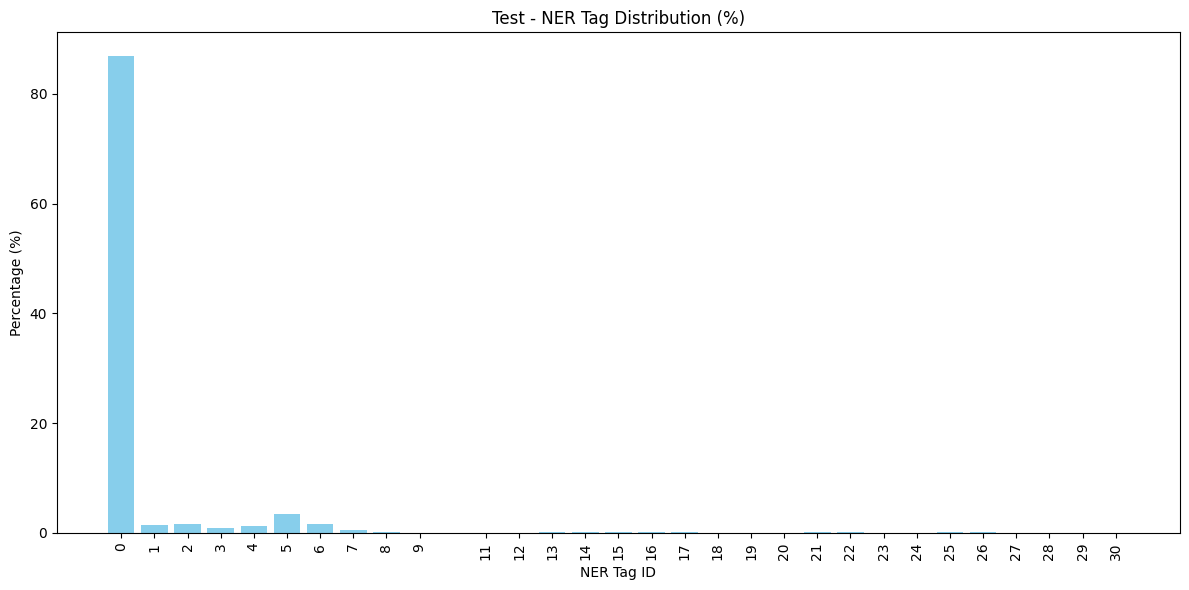

In [31]:
plot_ner_distribution(test_data, name="Test")

- Tag 0 ("O" label) still dominates (~85–90%).

- Other entity tags are very rare (<5% each).

### Sentence Length Analysis

# Test - Sentence Length Analysis

- Average: 21.09
- Max: 148
- Min: 4


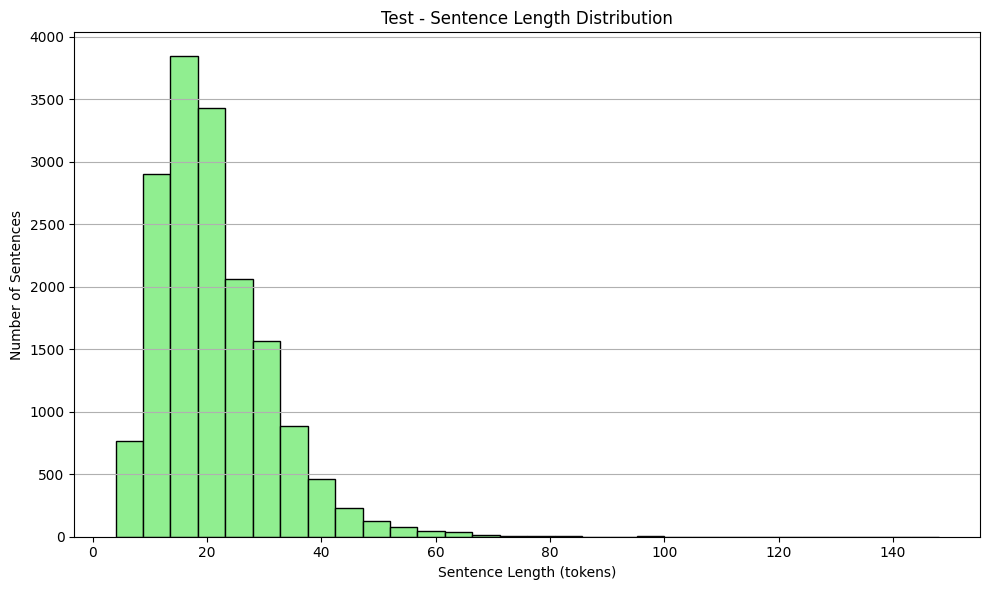

In [32]:
sentence_length_analysis(test_data, name="Test")

- Most sentences are between 15–30 tokens.

- Very few sentences are longer than 50 tokens.

- Long sentences (>100 tokens) are extremely rare.

### Entity Span Analysis

# Test - Entity Span Analysis

- Total entities: 25610
- Average entity span: 1.78 tokens
- Max span: 12 tokens
- Min span: 1 tokens


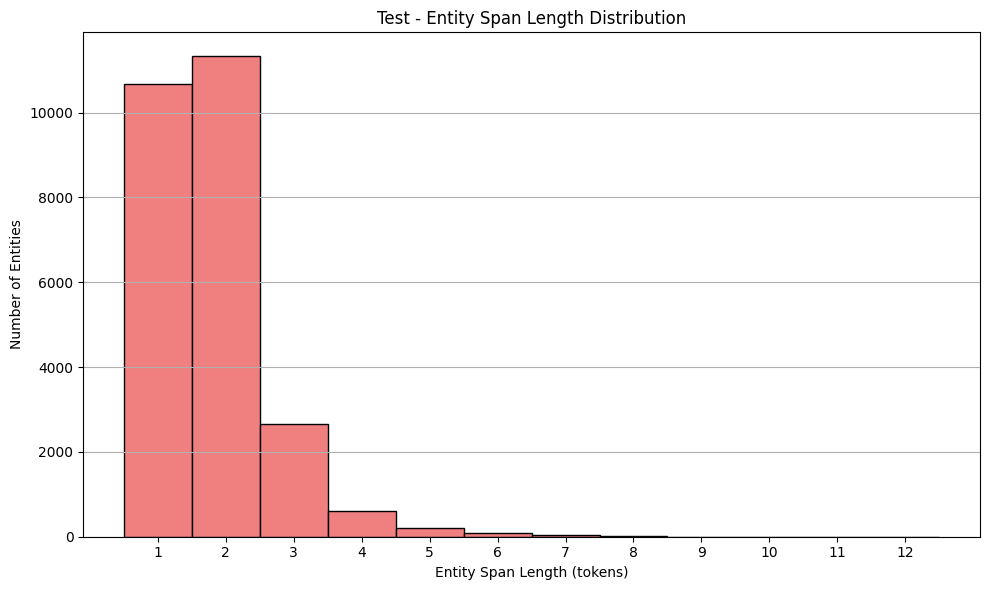

In [33]:
entity_span_analysis(test_data, name="Test")

- Most entities are 1–2 tokens long.

- Entities longer than 3 tokens are rare.

- Very few long entities (>5 tokens).



### Sample Sentences

In [34]:
preview_random_sentences(test_data, name="Test")

# Test - Random Sentence Samples

Sentence 1:
Tokens: It was endemic to Cuba .
NER Tags: [0, 0, 0, 0, 5, 0]

--------------------------------------------------

Sentence 2:
Tokens: This is added to spring onion , tomato , vegetable oil and rice .
NER Tags: [0, 0, 0, 0, 0, 0, 0, 25, 0, 0, 0, 0, 0, 0]

--------------------------------------------------

Sentence 3:
Tokens: This , however , had the indirect effect of promoting the trade across the Caspian Sea .
NER Tags: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 0]

--------------------------------------------------



# EDA Conclusion

- NER tag distributions are highly imbalanced across all datasets, with Tag 0 ("O") dominating (~85–90%).

- Sentence lengths are mostly short to medium (15–30 tokens) in all sets.

- Entity spans are mostly 1–2 tokens, with very few longer entities.

- Patterns are consistent across Train, Validation, and Test sets.